# Melanoma analysis with Inception ResNet V2

This notebook shows how good is [Inception ResNet V2](#Inception-ResNet-V2) for [melanoma](#Melanoma) analysis.

In [1]:
import os
import datetime
import numpy as np
import tensorflow as tf
import tensorflow_hub as hub
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc

Check if a GPU is available.

In [2]:
tf.config.list_physical_devices('GPU')

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

# Melanoma

__Melanoma__, also redundantly known as __malignant melanoma__, is a type of skin cancer that develops from the pigment-producing cells known as melanocytes. Melanomas typically occur in the skin, but may rarely occur in the mouth, intestines, or eye (uveal melanoma). In women, they most commonly occur on the legs, while in men, they most commonly occur on the back. About 25% of melanomas develop from moles. Changes in a mole that can indicate melanoma include an increase in size, irregular edges, change in color, itchiness, or skin breakdown.

![melanoma image](../assets/melanoma.jpg)

<div style="text-align: center; font-weight: bold">Pic.1. A melanoma of approximately 2.5 cm (1 in) by 1.5 cm (0.6 in)</div>

The primary cause of melanoma is ultraviolet light (UV) exposure in those with low levels of the skin pigment melanin. The UV light may be from the sun or other sources, such as tanning devices. Those with many moles, a history of affected family members, and poor immune function are at greater risk. A number of rare genetic conditions, such as xeroderma pigmentosum, also increase the risk. Diagnosis is by biopsy and analysis of any skin lesion that has signs of being potentially cancerous.

Melanoma is the most dangerous type of skin cancer. Globally, in 2012, it newly occurred in 232,000 people. In 2015, 3.1 million people had active disease, which resulted in 59,800 deaths. Australia and New Zealand have the highest rates of melanoma in the world. High rates also occur in Northern Europe and North America, while it is less common in Asia, Africa, and Latin America. In the United States, melanoma occurs about 1.6 times more often in men than women. Melanoma has become more common since the 1960s in areas mostly populated by people of European descent.

# Inception ResNet V2

__Inception-ResNet-v2__ is a convolutional neural architecture that builds on the Inception family of architectures but incorporates residual connections (replacing the filter concatenation stage of the Inception architecture).

![CNN image](../assets/inception_resnet_v2.png)

<div style="text-align: center; font-weight: bold">Pic.2. Inception ResNetv 2 architecture</div>

If you want to learn more about Inception ResNet v2, read [here](https://paperswithcode.com/method/inception-resnet-v2).

# Data loading

In [3]:
generator = tf.keras.preprocessing.image.ImageDataGenerator(
    rescale=1./255,
    rotation_range=180,
    horizontal_flip=True,
    vertical_flip=True,
    brightness_range=(0.2, 1.5),
    validation_split=0.2,
)


training_set = generator.flow_from_directory(
    f"{os.environ['SCRATCH']}/data10000", 
    target_size=(299, 299), 
    batch_size=32, 
    class_mode='categorical', 
    subset='training'
)
validation_set = generator.flow_from_directory(
    f"{os.environ['SCRATCH']}/data10000", 
    target_size=(299, 299), 
    batch_size=32, 
    class_mode='categorical', 
    subset='validation'
)

Found 7881 images belonging to 9 classes.
Found 1964 images belonging to 9 classes.


In [4]:
CLASS_NUMBER = len(training_set.class_indices)

### Data source

As a data source, we use the ISIC Archive.

The ISIC Archive is an open source platform with publicly available images of skin lesions under Creative Commons licenses. The images are associated with ground-truth diagnoses and other clinical metadata. Images can be queried using faceted search and downloaded individually or in batches. The initial focus of the archive has been on dermoscopy images of individual skin lesions, as these images are inherently standardized by the use of a specialized acquisition device and devoid of many of the privacy challenges associated with clinical images. To date, the images have been provided by specialized melanoma centers from around the world. The archive is designed to accept contributions from new sources under the Terms of Use and welcomes new contributors. There are ongoing efforts to supplement the dermoscopy images in the archive with close-up clinical images and a broader representation of skin types. The images in the Archive are used to support educational efforts through linkage with Dermoscopedia and are used for Grand Challenges and Live Challenges to engage the computer science community for the development of diagnostic AI.

For more information, go to [ISIC Archive web site](https://www.isic-archive.com/)

# Model training

### Building the model

We take the model from TensorFlow Hub. [Look here](https://tfhub.dev/google/tf2-preview/mobilenet_v2/feature_vector/4).

In [5]:
model = tf.keras.models.Sequential([
    hub.KerasLayer("https://tfhub.dev/google/imagenet/inception_resnet_v2/feature_vector/5",
                   trainable=False),
    tf.keras.layers.Dense(CLASS_NUMBER, activation='softmax')
])
model.build([None, 299, 299, 3])

In [6]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 keras_layer (KerasLayer)    (None, 1536)              54336736  
                                                                 
 dense (Dense)               (None, 9)                 13833     
                                                                 
Total params: 54,350,569
Trainable params: 13,833
Non-trainable params: 54,336,736
_________________________________________________________________


In [7]:
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

### Preparing TensorFlow callbacks

For our convenience, we create a few TensorFlow callbacks.

#### The TensorBoard callback

We want to see how the training is going. We add the callback, which will log the metrics to TensorBoard.

In [8]:
log_dir = '../logs/fit/' + datetime.datetime.now().strftime('inception_resnet_v2')
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=log_dir, histogram_freq=1)

#### The EarlyStopping callback

This callback stops training when the metrics (e.g. validation loss) are not improving,

In [9]:
early_stop_callback = tf.keras.callbacks.EarlyStopping(
    monitor="val_loss", 
    min_delta=0.01, 
    patience=5, 
    restore_best_weights=True
)

#### The ModelCheckpoint callback

This callback saves the model with the best metrics during training.

In [10]:
checkpoint_path = 'checkpoints/inception_resnet_v2.ckpt'

checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
    checkpoint_path,
    monitor='val_loss',
    verbose=1,
    save_best_only=True,
    save_weights_only=False,
    save_freq='epoch',
    mode='auto'
)

### Training the model

In [11]:
model.fit(
    training_set, 
    validation_data=validation_set, 
    epochs=200, 
    callbacks=[
                tensorboard_callback,
                checkpoint_callback,
                early_stop_callback
            ]
)

Epoch 1/200
247/247 [==============================] - ETA: 0s - loss: 0.6268 - accuracy: 0.8133 
Epoch 1: val_loss improved from inf to 0.51645, saving model to checkpoints/inception_resnet_v2.ckpt
INFO:tensorflow:Assets written to: checkpoints/inception_resnet_v2.ckpt/assets


INFO:tensorflow:Assets written to: checkpoints/inception_resnet_v2.ckpt/assets


247/247 [==============================] - 4612s 19s/step - loss: 0.6268 - accuracy: 0.8133 - val_loss: 0.5164 - val_accuracy: 0.8213
Epoch 2/200
247/247 [==============================] - ETA: 0s - loss: 0.5253 - accuracy: 0.8259 
Epoch 2: val_loss did not improve from 0.51645
247/247 [==============================] - 4709s 19s/step - loss: 0.5253 - accuracy: 0.8259 - val_loss: 0.6186 - val_accuracy: 0.8187
Epoch 3/200
247/247 [==============================] - ETA: 0s - loss: 0.4971 - accuracy: 0.8321 
Epoch 3: val_loss improved from 0.51645 to 0.50155, saving model to checkpoints/inception_resnet_v2.ckpt
INFO:tensorflow:Assets written to: checkpoints/inception_resnet_v2.ckpt/assets


INFO:tensorflow:Assets written to: checkpoints/inception_resnet_v2.ckpt/assets


247/247 [==============================] - 4578s 19s/step - loss: 0.4971 - accuracy: 0.8321 - val_loss: 0.5015 - val_accuracy: 0.8299
Epoch 4/200
247/247 [==============================] - ETA: 0s - loss: 0.4797 - accuracy: 0.8330 
Epoch 4: val_loss improved from 0.50155 to 0.49412, saving model to checkpoints/inception_resnet_v2.ckpt
INFO:tensorflow:Assets written to: checkpoints/inception_resnet_v2.ckpt/assets


INFO:tensorflow:Assets written to: checkpoints/inception_resnet_v2.ckpt/assets


247/247 [==============================] - 4392s 18s/step - loss: 0.4797 - accuracy: 0.8330 - val_loss: 0.4941 - val_accuracy: 0.8315
Epoch 5/200
247/247 [==============================] - ETA: 0s - loss: 0.4640 - accuracy: 0.8401 
Epoch 5: val_loss improved from 0.49412 to 0.48890, saving model to checkpoints/inception_resnet_v2.ckpt
INFO:tensorflow:Assets written to: checkpoints/inception_resnet_v2.ckpt/assets


INFO:tensorflow:Assets written to: checkpoints/inception_resnet_v2.ckpt/assets


247/247 [==============================] - 4276s 17s/step - loss: 0.4640 - accuracy: 0.8401 - val_loss: 0.4889 - val_accuracy: 0.8310
Epoch 6/200
247/247 [==============================] - ETA: 0s - loss: 0.4531 - accuracy: 0.8410 
Epoch 6: val_loss did not improve from 0.48890
247/247 [==============================] - 4413s 18s/step - loss: 0.4531 - accuracy: 0.8410 - val_loss: 0.5228 - val_accuracy: 0.8254
Epoch 7/200
247/247 [==============================] - ETA: 0s - loss: 0.4484 - accuracy: 0.8461 
Epoch 7: val_loss did not improve from 0.48890
247/247 [==============================] - 4400s 18s/step - loss: 0.4484 - accuracy: 0.8461 - val_loss: 0.5043 - val_accuracy: 0.8310
Epoch 8/200
247/247 [==============================] - ETA: 0s - loss: 0.4422 - accuracy: 0.8447 
Epoch 8: val_loss did not improve from 0.48890
247/247 [==============================] - 4299s 17s/step - loss: 0.4422 - accuracy: 0.8447 - val_loss: 0.4924 - val_accuracy: 0.8274
Epoch 9/200
247/247 [========

# Model validation

### Loading the model

We load the model with the best metrics (e.g. validation loss) from the checkpoint.

In [12]:
model = tf.keras.models.Sequential([
    hub.KerasLayer("https://tfhub.dev/google/imagenet/inception_resnet_v2/feature_vector/5",
                   trainable=False),
    tf.keras.layers.Dense(CLASS_NUMBER, activation='softmax')
])
model.build([None, 299, 299, 3])

In [13]:
model.load_weights('./checkpoints/inception_resnet_v2.ckpt')

### Loading the test data

In [14]:
testing_set = generator.flow_from_directory(
    f"{os.environ['SCRATCH']}/data10000-test",
    target_size=(299, 299),
    batch_size=32,
    class_mode='categorical'
)

Found 9843 images belonging to 9 classes.


### Making diagnoses

In [15]:
true_labels = np.concatenate([testing_set[i][1] for i in range(len(testing_set))], axis=0)

In [16]:
predicted_labels = model.predict(testing_set)

### Plot the ROC Curve

In [17]:
fpr = dict()
tpr = dict()
auc_metric = dict()

diagnosis_index_dict = {v: k for k, v in testing_set.class_indices.items()}

for i in range(CLASS_NUMBER):
    diagnosis = diagnosis_index_dict[i]
    fpr[diagnosis], tpr[diagnosis], _ = roc_curve(true_labels[:, i], predicted_labels[:, i])
    auc_metric[diagnosis] = auc(fpr[diagnosis], tpr[diagnosis])

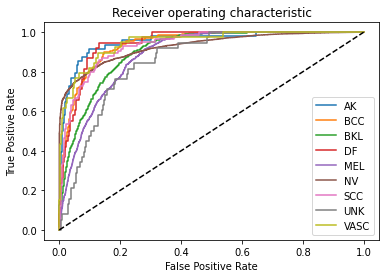

In [18]:
%matplotlib inline
for diagnosis in testing_set.class_indices:
    plt.plot(fpr[diagnosis], tpr[diagnosis], label=diagnosis)
    
plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic')
plt.legend(loc="lower right")
plt.show()

### Show AUC

In [19]:
auc_metric

{'AK': 0.9546707503828484,
 'BCC': 0.9406284351342942,
 'BKL': 0.9047243947927797,
 'DF': 0.9462116535602136,
 'MEL': 0.8852683284231957,
 'NV': 0.9291839907751651,
 'SCC': 0.9348110901292581,
 'UNK': 0.8556026731796345,
 'VASC': 0.9488722551758048}